GPT-1은 Transformer 모델에서 인코더를 제거한 디코더 기반의 모델로 Transformer 모델 구현에서
- Encoder 제거
- Decoder에서 encoder-decoder attention 제거

통해 모델을 구현하고자 한다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step 1. 데이터 수집

In [2]:
data_path = "~/aiffel/transformer_chatbot/data/ChatbotData .csv"
data = pd.read_csv(data_path, encoding='utf-8')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
#데이터 개수
len(data)

11823

In [4]:
#결측치 확인
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

### Step 2. 데이터 전처리

label열은 필요없는 데이터이므로 제거한다.

In [5]:
data = data[['Q','A']]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [6]:
MAX_SAMPLES = 50000 # 사용할 샘플의 최대 수

def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence) # 구두점 앞/뒤 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러 공백을 하나의 공백으로 변환
    
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip() # 문자열의 양쪽 끝에 있는 모든 공백 제거
    
    return sentence

In [7]:
def load_conversations(question, answer):
    inputs, outputs = [], []
    
    for Q,A in zip(question, answer):
        inputs.append(preprocess_sentence(Q))
        outputs.append(preprocess_sentence(A))
        
        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
        
    return inputs, outputs

In [8]:
questions, answers = load_conversations(data['Q'], data['A'])
print(f"전체 샘플 수 : {len(data['Q'])} {len(data['A'])}")

전체 샘플 수 : 11823 11823


질문과 답변은 병렬적인 데이터 셋이므로 두 샘플 수가 정확히 일치하는 것을 확인했다.

### Step 3. SubwordTextEncoder

**1. 토큰화**

TensorFlow Datasets SubwordTextEncoder

: 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징

: 각 토큰을 고유한 정수로 인코딩 한다.

=> SubwordTextEncdoer을 사용해 단어장을 만들고자 한다.

In [9]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
# target_vocab_size(목표 어휘 크기) : 2의 13제곱(8192)게의 토큰

디코더의 문장 생성 과정에서 사용할 '시작토큰' '종료토큰'을 단어장에 추가한다.

In [10]:
print('단어장의 단어 개수 : ',tokenizer.vocab_size)

단어장의 단어 개수 :  8170


In [11]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [12]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


2개의 토큰을 추가하였으므로 단어의 크기도 +2해줘야 한다.

In [13]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


**2. 각 단어를 고유한 정수로 인코딩 & 패딩**

각 샘플의 길이를 통해 최대 샘플의 길이를 설정하고자 한다.

In [14]:
Q_length = [len(question) for question in questions]
A_length = [len(answer) for answer in answers]

#평균
avg_Q = sum(Q_length)/len(Q_length)
avg_A = sum(A_length)/len(A_length)

print("Q의 평균 길이 : %.2f" %avg_Q)
print("A의 평균 길이 : %.2f" %avg_A)

print(f'Q의 최대 길이 : {max(Q_length)}')
print(f'A의 최대 길이 : {max(A_length)}')

print(f'Q의 최소 길이 : {min(Q_length)}')
print(f'A의 최소 길이 : {max(A_length)}')

Q의 평균 길이 : 13.23
A의 평균 길이 : 16.04
Q의 최대 길이 : 57
A의 최대 길이 : 78
Q의 최소 길이 : 1
A의 최소 길이 : 78


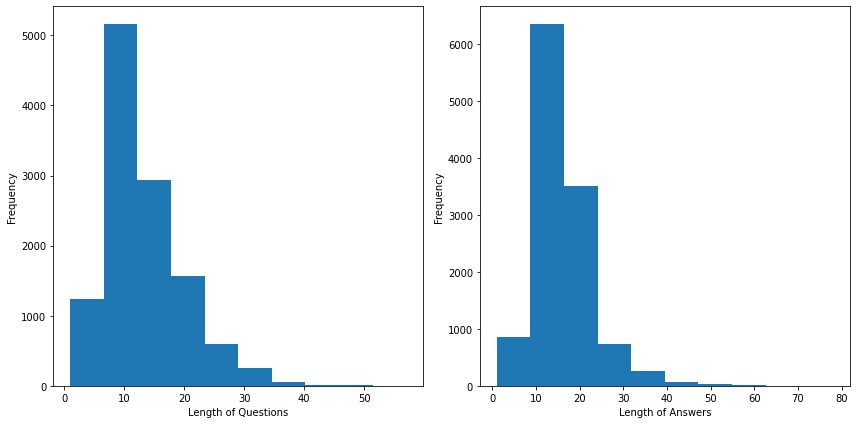

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.hist(Q_length)
plt.xlabel('Length of Questions')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(A_length)
plt.xlabel('Length of Answers')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

=> maxlen=40으로 결정

In [16]:
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        #길이40미만 사용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    #길이 40으로 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_outputs, maxlen = MAX_LENGTH, padding = 'post')
    
    return tokenized_inputs, tokenized_outputs
        

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### Step 4. 모델 구성

**Transformer 구현**

Transformer은 문장 속 단어와 같은 순차 데이터 내의 관계를 추적해 의미와 맥락을 학습하는 신경망 모델로 해당 데이터에 적합한 모델

- 1. positional encoding layer : 위치정보

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- 2. scaled dot product attention : 유사도 계산

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):

    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

- 3. 멀티헤드어텐션

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

- 4. 마스킹 함수 : 불필요한 단어 가리기

In [21]:
# 패딩 마스킹 

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
# 룩 어헤드 마스킹

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

- **6.Decoder layer 구현 : 멀티 헤드 셀프 어텐션 + 인코더-디코더 어텐션 + FF**

In [23]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 셀프 어텐션
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask})#룩어헤드마스킹
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)
    
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

- 6+.여러 개의 decoderlayer을 쌓아서 Decoder 구현

In [59]:
def decoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name='decoder'):
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,output_shape=(1, None, None),name='look_ahead_mask')(dec_inputs)
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(dec_inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs, look_ahead_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

    return tf.keras.Model(
        inputs=[dec_inputs],
        outputs=outputs,
        name=name)

In [60]:
BATCH_SIZE = 64 # 각 배치에서 처리할 데이터 샘플 수
BUFFER_SIZE = 20000 # 데이터를 섞을 때 사용되는 버퍼 크기

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:] #start_token제거
    },
))

dataset = dataset.cache()#데이터를 메모리or디스크에 cache해 반복적인 데이터 로딩방지
dataset = dataset.shuffle(BUFFER_SIZE)#데이터섞
dataset = dataset.batch(BATCH_SIZE)#배치크기로나누기
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)#학습 중 데이터 전처리와 모델 실행을 병렬적으로 수행
# tensorflow가 적절한 프리페치 크기를 자동(AUTOTUNE)으로 설정

In [61]:
#모델 생성

tf.keras.backend.clear_session()
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2092032     dec_inputs[0][0]                 
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 256)    0           tf.math.multiply[0][0]           
____________________________________________________________________________________________

In [62]:
#시퀀스에 패딩되어 있기 때문에 loss를 계산할 때 패딩 마스크를 적용한다.

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask) #패딩부분을 제외하고 실제 값이 있는 부분에 대해서만 손실 계산
    #multiply함수 : element-wise곱셈 수행
    
    return tf.reduce_mean(loss)#평균손실 반환

In [63]:
#커스텀 학습률 스케즐러를 통한 Adam 옵티마이저

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 학습

In [64]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [65]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks = [early_stopping])

Epoch 1/20
185/185 [==============================] - 10s 33ms/step - loss: 1.4584 - accuracy: 0.0341
Epoch 2/20
185/185 [==============================] - 6s 32ms/step - loss: 1.1750 - accuracy: 0.0495
Epoch 3/20
185/185 [==============================] - 6s 32ms/step - loss: 1.0003 - accuracy: 0.0507
Epoch 4/20
185/185 [==============================] - 6s 32ms/step - loss: 0.9235 - accuracy: 0.0542
Epoch 5/20
185/185 [==============================] - 6s 33ms/step - loss: 0.8634 - accuracy: 0.0578
Epoch 6/20
185/185 [==============================] - 6s 33ms/step - loss: 0.8042 - accuracy: 0.0623
Epoch 7/20
185/185 [==============================] - 6s 33ms/step - loss: 0.7414 - accuracy: 0.0680
Epoch 8/20
185/185 [==============================] - 6s 33ms/step - loss: 0.6760 - accuracy: 0.0750
Epoch 9/20
185/185 [==============================] - 6s 33ms/step - loss: 0.6089 - accuracy: 0.0821
Epoch 10/20
185/185 [==============================] - 6s 33ms/step - loss: 0.5450 - accur

### Step 5. 모델 평가

예측 단계
- 새로운 입력 문장에 대해서 전처리
- 입력 문장을 tokenizer, start&end token 추가
- 패딩 마스킹, 룩 어헤드 마스킹 계산
- 디코더는 입력 시퀀스로부터 다음 단어 예측
- 디코더는 예측된 다음 단어를 기존 입력 시퀀스에 추가하여 새로운 입력으로 사용
- end token이 예측되거나 문장의 최대 길이에 도달하면 디코더 동작 stop

In [69]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence) # 전치리

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [70]:
# decoder_inference를 호출하여 챗봇의 대답을 얻는 함수

def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [71]:
Q_lists = ['안녕', '너의 이름은 뭐야?','너는 사람이야?', '저녁 메뉴 추천해줘.','나 친구랑 싸워서 기분이 안좋아.','1234 + 1234 계산 결과가 뭐야?','sin함수에 대해서 설명해줘.']

for i in Q_lists:
    sentence_generation(i)
    print('\n')

입력 : 안녕
출력 :                                         


입력 : 너의 이름은 뭐야?
출력 : 


입력 : 너는 사람이야?
출력 :                                         


입력 : 저녁 메뉴 추천해줘.
출력 : 


입력 : 나 친구랑 싸워서 기분이 안좋아.
출력 : 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 고 


입력 : 1234 + 1234 계산 결과가 뭐야?
출력 : 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 으면 


입력 : sin함수에 대해서 설명해줘.
출력 : 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 할 




< 어려웠던 점 >
- Transformer에서는 encoder input과 decoder input의 차이가 존재하는데 Decoder로만 수행하면 어떻게 처리해야하는지 해결하지 못했다.
=> 무턱대고 encoder연결과 encoder관련 층은 모두 제거해서 모델을 구현했다.
- GPT에 대한 완전한 이해없이 정답 없는 code를 구현하는 것이 어려웠으며
- 지속되는 동일한 오류를 파악하고 수정하지 못해 최종 결과물을 도출하지 못했다.

- 주말을 이용해 GTP논문을 다시 한번 읽고 훈련 과정을 다시 구현해봐야겠다.